# 1. Get Data and preprocess it 

In [1]:
import os,torch, torchvision, pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from pathlib import Path


In [2]:
import os

directory = "../Data"
def print_directory_file_counts(directory):
    """
    Prints the name of each directory and the number of files it contains.

    Args:
        directory (str): Path to the root directory.
    """
    for root, dirs, files in os.walk(directory):
        # Use the folder name instead of the full path for simplicity
        dir_name = os.path.basename(root) or root  # Handles the root folder name
        file_count = len(files)
        print(f"Directory: {dir_name}, Files: {file_count}")
print_directory_file_counts(directory)




Directory: Data, Files: 0
Directory: test, Files: 0
Directory: adenocarcinoma, Files: 120
Directory: large.cell.carcinoma, Files: 51
Directory: normal, Files: 54
Directory: squamous.cell.carcinoma, Files: 90
Directory: train, Files: 0
Directory: adenocarcinoma, Files: 195
Directory: large.cell.carcinoma, Files: 115
Directory: normal, Files: 148
Directory: squamous.cell.carcinoma, Files: 155
Directory: valid, Files: 0
Directory: adenocarcinoma, Files: 23
Directory: large.cell.carcinoma, Files: 21
Directory: normal, Files: 13
Directory: squamous.cell.carcinoma, Files: 15


## 1.1 Creating Dataset class for Chest x ray data

In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform):
        """
        Args:
            root_dir (str): Path to the directory containing class folders.
            transform (callable): Transformations to apply to the images.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Folder names as class labels
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map folder name to class index
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = self.root_dir /  Path(cls)
            for img_file in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_file))
                self.labels.append(self.class_to_idx[cls])
    

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
test_dataset = ChestXrayDataset(root_dir="../Data/test", transform=transforms.ToTensor())
train_dataset = ChestXrayDataset(root_dir="../Data/train", transform=transforms.ToTensor())
valid_dataset = ChestXrayDataset(root_dir="../Data/valid", transform=transforms.ToTensor())


## 1.1 creating Dataloaders 

In [10]:
from torchvision.models import DenseNet121_Weights

# Specify the weights to use from the DenseNet121 model
weights = DenseNet121_Weights.DEFAULT
# Get the transforms associated with the weights
Densenet_transforms = weights.transforms()

test_dataset = ChestXrayDataset(root_dir="../Data/test", transform=Densenet_transforms)
train_dataset = ChestXrayDataset(root_dir="../Data/train", transform=Densenet_transforms)
valid_dataset = ChestXrayDataset(root_dir="../Data/valid", transform=Densenet_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)



## 1.2 Visualizing some examples 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


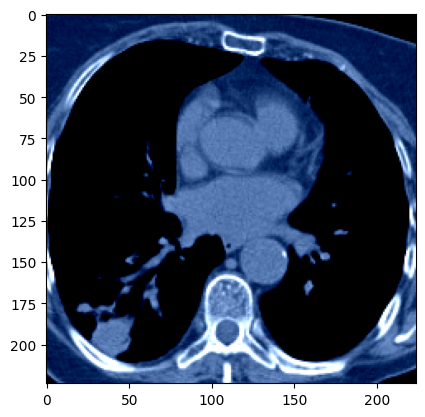

In [15]:
import matplotlib.pyplot as plt
img = next(iter(train_dataloader))[0]
plt.imshow(img[0].permute(1, 2, 0))

In [17]:
%%writefile ../src/Chest_Cancer_Classification/utils/data_setup.py
"""
    Setsup the data for the model
"""
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import os
from torchvision.models import DenseNet121_Weights
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform):
        """
        Args:
            root_dir (str): Path to the directory containing class folders.
            transform (callable): Transformations to apply to the images.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Folder names as class labels
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map folder name to class index
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = self.root_dir / Path(cls)
            for img_file in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_file))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def get_data_loaders(root_dir, batch_size=32):
    # Specify the weights to use from the DenseNet121 model
    weights = DenseNet121_Weights.DEFAULT
    # Get the transforms associated with the weights
    densenet_transforms = weights.transforms()

    # Initialize datasets
    train_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "train"), transform=densenet_transforms)
    test_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "test"), transform=densenet_transforms)
    valid_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "valid"), transform=densenet_transforms)

    # Initialize data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader, valid_dataloader, train_dataset.classes

Writing ../src/Chest_Cancer_Classification/utils/data_setup.py


# 2. Creating a Model